# "Global Biodiversity" Widget

This widget is a horizontally oriented histogram, breaking sub regions into buckets of 'Very High' to 'Very Low' Intactness or Significance.

Due to the heavily qualitative nature of the data we are unable to quote any numerical values, nor make direct comparisons between subregions.

In the face of that the histogram will only display the percentage of subregions that fall into each bucket as a percentage.

Along side the histogram 

User Variables:

1. Admin-0, -1 and -2 region
2. number of subregions or %
3. Biodiversity Intactness or Significance

On Hover:

When a user hovers on a bar the dynamic sentence should change to reflect the value of the bar.

Tabs: ['Conservation']

# Note

A few issues:

- data is non-central (Intactness has a long tail and fignificance is exponential)
- size and number of many buckets (5 or 7? 1 sigma?)
- Should mean and std be global or locally calculated?

In [153]:
import os
import ee
import json
import requests
import requests_cache
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as stats

ee.Initialize()

In [2]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [62]:
# Make the query and return data
def biodiversity_query(adm0=None, adm1=None):
             
    if adm1:
        print('Request for adm2 areas')
        sql = (f"SELECT iso, adm1, adm2, significance AS sig, intactness AS int "
               f"FROM global_biodiversity_table "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} ")
               
    elif adm0:
        print('Request for  adm1 areas')
        sql = (f"SELECT iso, adm1, adm2, significance AS sig, intactness AS int "
               f"FROM global_biodiversity_table "
               f"WHERE iso = '{adm0}' ")
        
    else:
        print('Request adm0 areas')
        sql = (f"SELECT iso, adm1, adm2, significance AS sig, intactness AS int "
               f"FROM global_biodiversity_table ")
    
    account = 'wri-01'
    urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

    sql = {"q": sql}
    r = requests.get(urlCarto, params=sql)
    print(r.url,'\n')
    # pprint(r.json())
    data = r.json().get('rows')
    
    return data

In [388]:
adm0 = None
adm1 = None

data = biodiversity_query(adm0=adm0, adm1=adm1)

Request adm0 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1%2C+adm2%2C+significance+AS+sig%2C+intactness+AS+int+FROM+global_biodiversity_table+ 



In [389]:
"""NOTE significance is exponential and ranges from 0 - 190,000
        intactness is linear and ranges from -100 - 0"""

data[0:3]

[{'adm1': 17,
  'adm2': 181,
  'int': -27.6040841675594,
  'iso': 'AFG',
  'sig': 5.77854612866165},
 {'adm1': 18,
  'adm2': 185,
  'int': -20.5403704321043,
  'iso': 'AFG',
  'sig': 7.92993286262219},
 {'adm1': 18,
  'adm2': 186,
  'int': -17.3960070816717,
  'iso': 'AFG',
  'sig': 8.23205527801386}]

# Get Global Stats

In [391]:
ints = [-d.get('int') for d in data if d.get('int')]
sigs = [math.log(d.get('sig'),10) for d in data if d.get('sig')]


int_mean = np.mean(ints)
sig_mean = np.mean(sigs)

int_std = np.std(ints)
sig_std = np.std(sigs)

int_min = min(ints)
sig_min = min(sigs)

int_max = max(ints)
sig_max = max(sigs)


In [392]:
int_mean, int_std, int_min, int_max, len(ints)

(18.897645087752558,
 12.128387190174665,
 -2.52287461925259,
 96.0362309086158,
 36768)

In [393]:
sig_mean, sig_std, sig_min, sig_max, len(sigs)

(0.41021976041473202,
 0.70436747388513643,
 -3.202517393325241,
 5.270138891140876,
 36760)

- Get a list of sub regions' in and sig values
- build a distribution
- pick bounds
- bucket into 'V. High', 'High', 'Normal', 'Low', 'V. Low'

In [384]:
binwidth = int_std

(array([  9.21400000e+03,   1.23990000e+04,   1.23480000e+04,
          2.10800000e+03,   3.78000000e+02,   1.70000000e+02,
          1.00000000e+02,   4.40000000e+01,   7.00000000e+00]),
 array([  -2.52287462,    9.60551257,   21.73389976,   33.86228695,
          45.99067414,   58.11906133,   70.24744852,   82.37583571,
          94.5042229 ,  106.63261009]),
 <a list of 9 Patch objects>)

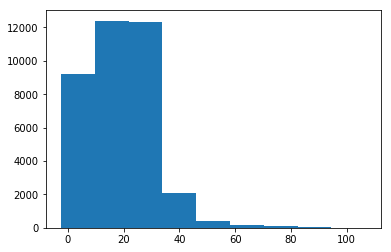

In [385]:
plt.hist(ints, bins=np.arange(min(ints), max(ints) + binwidth, binwidth))

In [386]:
binwidth = sig_std

(array([  4.00000000e+00,   5.00000000e+00,   6.70000000e+01,
          6.56300000e+03,   1.01390000e+04,   1.19680000e+04,
          7.14100000e+03,   7.80000000e+02,   6.00000000e+01,
          1.60000000e+01,   9.00000000e+00,   6.00000000e+00,
          2.00000000e+00]),
 array([-3.20251739, -2.49814992, -1.79378245, -1.08941497, -0.3850475 ,
         0.31931998,  1.02368745,  1.72805492,  2.4324224 ,  3.13678987,
         3.84115735,  4.54552482,  5.24989229,  5.95425977]),
 <a list of 13 Patch objects>)

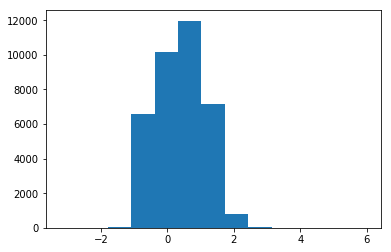

In [387]:
plt.hist(sigs, bins=np.arange(min(sigs), max(sigs) + binwidth, binwidth))

# NOTE

- log(significance) seems to be normally distributed with a spike of low-significance regions
- intactness is more Maxwell-Boltzmann (poisson stats), again taking a log normalises a little...

# Widget

Users can select

### To do

1. Get mean and std
2. create buckets from these
3. count number in each bucket
4. calc percentage


In [296]:
def getLocalStats(data, metric='int'):
    if metric == 'int':
        values = [-d.get('int') for d in data if d.get('int')]
    elif metric == 'sig':
        values = [math.log(d.get('sig'),10) for d in data if d.get('sig')]
    
    mean = np.mean(values)
    std = np.std(values)
    
    return {'mean': mean, 'std': std}

In [367]:
def getHistogram(data):
    
    metrics = ['int', 'sig']
    tmp = {} 

    for metric in metrics:
        
        counts = {

            'extremely high': 0,
            'very high': 0,
            'high': 0,
            'normal': 0,
            'low': 0,
            'very low': 0,
            'extremely low': 0

        }
        
        mean = getLocalStats(data, metric).get('mean')
        std = getLocalStats(data, metric).get('std')
        
        for d in data:
            if metric == 'int':
                value = -d.get(metric)
            elif metric == 'sig' and d.get('sig'):
                value = math.log(d.get('sig'))

            if (value > mean + 3*std):
                counts['extremely high'] += 1
            elif (value >= mean + 2*std) and (value < mean + 3*std):
                counts['very high'] += 1
            elif (value >= mean + 1*std) and (value < mean + 2*std):
                counts['high'] += 1
            elif (value >= mean - 1*std) and (value < mean + 1*std):
                counts['normal'] += 1
            elif (value >= mean - 2*std) and (value < mean - 1*std):
                counts['low'] += 1
            elif (value >= mean - 3*std) and (value < mean - 2*std):
                counts['very low'] += 1
            elif (value > mean - 3*std):
                counts['extremely low'] += 1

        total = sum(counts.values())
    
        tmp[metric] = {k: round(100 * v / total, 2) for k,v in counts.items()}
    
    return tmp


In [368]:
getHistogram(data)

{'int': {'extremely high': 1.02,
  'extremely low': 0.0,
  'high': 11.19,
  'low': 17.82,
  'normal': 68.64,
  'very high': 1.33,
  'very low': 0.0},
 'sig': {'extremely high': 18.98,
  'extremely low': 0.0,
  'high': 15.15,
  'low': 15.23,
  'normal': 24.07,
  'very high': 13.8,
  'very low': 12.76}}

# Dynamic Sentence

In [373]:
def getSentence(hist, selected, metric): 
    
    pprint(hist)
    
    if(metric == 'int'):
        label = 'intacteness'
    elif(metric == 'sig'):
        label = 'signficance'

    areaId_to_name = None
    if adm2:
        tmp = get_admin2_json(iso=adm0, adm1=adm1)
        areaId_to_name ={}
        for row in tmp:
            areaId_to_name[row.get('adm2')] = row.get('name')
    if adm1 and not adm2:
        tmp = get_admin1_json(iso=adm0)
        areaId_to_name={}
        for row in tmp:
            areaId_to_name[row.get('adm1')] = row.get('name')

    if not adm0 and  not adm1 and not adm2:
        title = ("countries globally")
    if adm0 and not adm1 and not adm2:
        title = (f"regions in{iso_to_countries[adm0]}")
    if adm0 and adm1 and not adm2: 
        title = (f"subregions in {areaId_to_name[adm1]}")

    print("")
    print(f"Around {hist[metric][selected]}% of {title} have a {selected} degree of biodiversity {label} on average.", end="")


# Examples

In [376]:
adm0 = None #GLOBAL
adm1 = None

data = biodiversity_query(adm0=adm0, adm1=adm1)
hist = getHistogram(data)

Request adm0 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1%2C+adm2%2C+significance+AS+sig%2C+intactness+AS+int+FROM+global_biodiversity_table+ 



In [377]:
getSentence(hist, 'very high','int')

{'int': {'extremely high': 1.02,
         'extremely low': 0.0,
         'high': 11.19,
         'low': 17.82,
         'normal': 68.64,
         'very high': 1.33,
         'very low': 0.0},
 'sig': {'extremely high': 18.98,
         'extremely low': 0.0,
         'high': 15.15,
         'low': 15.23,
         'normal': 24.07,
         'very high': 13.8,
         'very low': 12.76}}

Around 1.33% of countries globally have a very high degree of biodiversity intacteness on average.

In [379]:
getSentence(hist, 'normal','sig')

{'int': {'extremely high': 1.02,
         'extremely low': 0.0,
         'high': 11.19,
         'low': 17.82,
         'normal': 68.64,
         'very high': 1.33,
         'very low': 0.0},
 'sig': {'extremely high': 18.98,
         'extremely low': 0.0,
         'high': 15.15,
         'low': 15.23,
         'normal': 24.07,
         'very high': 13.8,
         'very low': 12.76}}

Around 24.07% of countries globally have a normal degree of biodiversity signficance on average.